In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Reposiktories/'

In [2]:
""" 
IMPORTS
"""
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
import pandas as pd
from one.api import ONE
import pickle
from scipy.stats import zscore

from one.api import ONE
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.hidden_markov_model import PoissonHMM

one = ONE(mode='remote')

# Get my functions
from functions import *

ERROR:2025-09-22 13:39:43,140:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 324, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 281, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE


## Parameters

In [3]:

""" FITTING PARAMETERS """
num_iters = 100
num_states = 2
num_train_batches = 5
method='prior'
fit_method='em'
zsc = True
truncate = False

if truncate:
    fitting_params = str(num_train_batches)+'_'+method+'_'+fit_method+'_zsc_'+str(zsc)+'_truncated/'
else:
    fitting_params = str(num_train_batches)+'_'+method+'_'+fit_method+'_zsc_'+str(zsc)+'/'

# whisker_params = str(num_train_batches)+'_'+method+'_'+fit_method+'_zsc_'+'True/'
# licking_params = str(num_train_batches)+'_'+method+'_'+fit_method+'_zsc_'+'False/'

save_path = prefix + 'representation_learning_variability/paper-individuality/data/hmm/most_likely_states/'+fitting_params

# Create folder where to dump data
if not os.path.exists(save_path):
    # Create a new directory because it does not exist
    os.makedirs(save_path)
        
# LOAD DATA
data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
wavelet_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_wavelets/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices)

var_interest = ['Lick count']
var_interest = ['whisker_me']


# Individual sessions

In [4]:
# Identify sessions availableto process
grid_search_path = prefix + 'representation_learning_variability/paper-individuality/data/hmm/grid_search/'+fitting_params
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    result_filename = os.path.join(grid_search_path, f"best_results_{var_interest[0]}_{fit_id}")
    if os.path.exists(result_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 218 sessions to process.


In [5]:
for m, mat in enumerate(sessions_to_process):
        
    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    filename = wavelet_path + "paw_vel_wavelets_" + str(session) + '_'  + mouse_name
    original_design_matrix = pd.read_parquet(filename)
    # filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    # original_design_matrix = pd.read_parquet(filename)
    
    design_matrix = original_design_matrix.dropna()[var_interest]
    
    if zsc == True:
        design_matrix[var_interest] = zscore(np.array(design_matrix), axis=0, nan_policy='omit')
    else:
        design_matrix[var_interest] = np.array(design_matrix)
        
    # Prepare data
    num_timesteps = np.shape(design_matrix)[0]
    emission_dim = np.shape(design_matrix)[1]
    shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

    results_file = os.path.join(grid_search_path, 
                                f"best_results_{var_interest[0]}_{fit_id}")
        
    # Retrieve best fits
    if 'Lick count' in var_interest:
        # Get results from grid search
        all_lls, all_baseline_lls, all_init_params, all_fit_params, _, params = pickle.load(open(results_file, "rb"))
        _, _, kappas = params
        param_num = 1 ## Only search kappas
        bits_LL, all_LL, best_fold = get_bits_LL(all_lls, all_baseline_lls, design_matrix, num_train_batches, params, param_num)
        # bits_LL, all_LL, best_fold = get_bits_LL_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
        # best_kappa = find_best_param(bits_LL, kappas)
        best_kappa, _, mean_bits_LL = find_best_param(bits_LL, params, param_num)
        index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
        use_fold = int(best_fold[index_kappa])

        " Fit model with best params"
        best_params = all_fit_params[best_kappa]
        best_parameters = num_states, np.nan, best_kappa
        # Find parameters for best fold
        initial_probs = best_params[0].probs[use_fold]
        transition_matrix = best_params[1].transition_matrix[use_fold]
        emission_rates = best_params[2].rates[use_fold]

        # Initialize new hmm
        test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=best_kappa)
        best_fold_params, props = test_phmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,
                                        emission_rates=emission_rates)  # not sure if I need to includea
        # Get state estimates for validation data
        most_likely_states = test_phmm.most_likely_states(best_fold_params, shortened_array)

        # # Plot grid search
        # plt.scatter([kappas]*num_train_batches, bits_LL)
        # plt.errorbar(kappas, np.nanmean(bits_LL, axis=1), np.nanstd(bits_LL, axis=1)/(np.sqrt(5))*1.96)
        # plt.xlabel('Kappa')
        # plt.xticks(np.arange(0, len(kappas), 1), kappas)
        # plt.title(mouse_name + ' ' + var_interest[0])
        # plt.show()
        print(best_kappa)
    else:
        # Get results from grid search
        all_lls, all_baseline_lls, all_init_params, all_fit_params, _, params = pickle.load(open(results_file, "rb"))
        _, Lags, kappas = params
        param_num = 2 ## Only search kappas
        bits_LL, all_LL, best_fold = get_bits_LL(all_lls, all_baseline_lls, design_matrix, num_train_batches, params, param_num)
        best_kappa, best_lag, mean_bits_LL = find_best_param(bits_LL, params, param_num)

        index_lag = np.where(np.array(Lags)==best_lag)[0][0]
        index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
        use_fold = int(best_fold[index_kappa, index_lag])
        
        best_parameters = num_states, best_lag, best_kappa
                
        " Fit model with best params"
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, best_lag, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))

        best_params = all_fit_params[best_lag][best_kappa]

        # Find parameters for best fold
        initial_probs = best_params[0].probs[use_fold]
        transition_matrix = best_params[1].transition_matrix[use_fold]
        emission_weights = best_params[2].weights[use_fold]
        emission_biases = best_params[2].biases[use_fold]
        emission_covariances = best_params[2].covs[use_fold]

        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=best_lag, transition_matrix_stickiness=best_kappa)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases,
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include

        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

        # Plot grid search
        # plot_grid_search(best_kappa, best_lag, mean_bits_LL.T, kappas, Lags, mouse_name, var_interest[0])        
        # plt.scatter([Lags]*num_train_batches, bits_LL[index_kappa, :, :].T)
        # plt.plot(Lags, np.nanmean(bits_LL[index_kappa, :, :], axis=1))
        # plt.errorbar(Lags, np.nanmean(bits_LL[index_kappa, :, :], axis=1), np.nanstd(bits_LL[index_kappa, :, :], axis=1)/(np.sqrt(5))*1.96)
        # plt.ylabel('Delta LL')
        # plt.xlabel('Lag')
        # plt.show()
        # print(best_kappa, best_lag)
        
    to_save = most_likely_states, use_fold, best_parameters

    # Save most_likely_states
    pickle.dump(to_save, open(save_path + var_interest[0] + '_'+ fit_id , "wb"))


/home/ines/repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:549: RuntimeWarning: Mean of empty slice
  mean_vals = np.nanmean(arr, axis=axis)


## Test licks

Fitting session ZFM-023706f6d2c8e-28be-49f4-ae4d-06be2d3148c1...


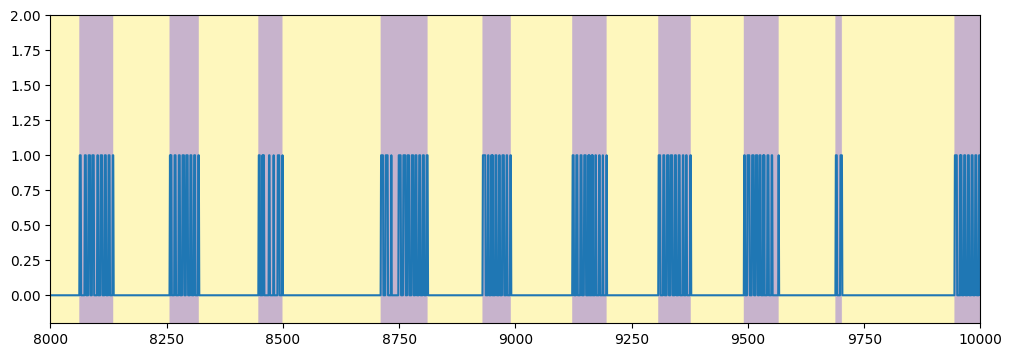

In [15]:
variables_to_fit = ['Lick count']
kappa = 0

for m, mat in enumerate(idxs[38:39]):
      mouse_name = mat[37:]
      session = mat[:36]

      # Load mouse/session data
      filename = "design_matrix_" + str(session) + '_'  + mouse_name
      original_design_matrix = pd.read_parquet(data_path + filename)


      # Need to dropnans
      if zsc == True:
              array_matrix = zscore(np.array(original_design_matrix), axis=0, nan_policy='omit')
      else:
              array_matrix = np.array(original_design_matrix)
              
      # filtered_matrix = np.abs(standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)])
      filtered_matrix = array_matrix[~np.isnan(array_matrix).any(axis=1)] # [:50000]
#       if variables_to_fit == ['avg_wheel_vel']:
#               filtered_matrix = np.abs(array_matrix[~np.isnan(array_matrix).any(axis=1)])
      keys = np.where(original_design_matrix.keys().isin(variables_to_fit))
      design_matrix = filtered_matrix[:, keys]
      design_matrix = np.reshape(design_matrix,(np.shape(design_matrix)[0], np.shape(design_matrix)[2]))
      fit_id = str(mouse_name + session)
      print(f"Fitting session {fit_id}...")

      # Prepare data format
      num_timesteps = np.shape(design_matrix)[0]
      emission_dim = np.shape(design_matrix)[1]
      shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
      train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

      test_poishmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=kappa)
      all_val_lls, fit_params, init_params, baseline_lls = cross_validate_poismodel(test_poishmm, jr.PRNGKey(0),
                                                                                        train_emissions, num_train_batches, 'em', num_iters=100)

      use_fold = np.where(all_val_lls==np.nanmax(all_val_lls))[0][0]
      # Find parameters for best fold
      initial_probs = fit_params[0].probs[use_fold]
      transition_matrix = fit_params[1].transition_matrix[use_fold]
      emission_rates = fit_params[2].rates[use_fold]

      # Initialize new hmm
      test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=kappa)
      best_fold_params, props = test_phmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,
                                        emission_rates=emission_rates)  # not sure if I need to include

      # Get state estimates for validation data
      most_likely_states = test_phmm.most_likely_states(best_fold_params, shortened_array)
      # Remove states below threshold
      new_states = np.array(most_likely_states).astype(float)
      new_states = most_likely_states

      " Plots "
      fig, ax = plt.subplots(figsize=(12, 4))
      states_to_append =np.arange(0, num_states, 1)
      plot_max = 500
      plot_min = -500

      plt.plot(np.array(design_matrix[:, 0]))
      plt.imshow(np.concatenate([most_likely_states, states_to_append])[None,:],
              extent=(0, len(np.concatenate([most_likely_states, states_to_append])), plot_min, plot_max),
              aspect="auto",
              cmap='viridis',
              alpha=0.3)
      plt.xlim([8000,10000])
      plt.ylim([-.2, 2])
      plt.show()

## Test whisking

Fitting session ZFM-0237288224abb-5746-431f-9c17-17d7ef806e6a...


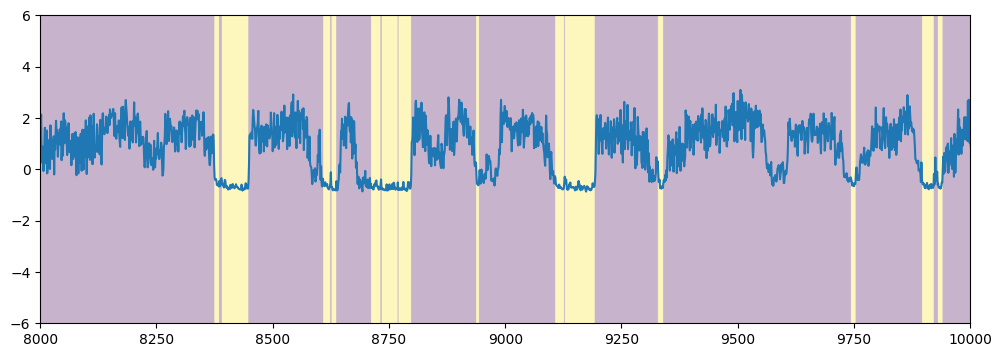

In [5]:
variables_to_fit = ['whisker_me']
# variables_to_fit = ['avg_wheel_vel']
num_lags = 1
kappa=0
for m, mat in enumerate(idxs[:1]):
      mouse_name = mat[37:]
      session = mat[:36]

      # Load mouse/session data
      filename = "design_matrix_" + str(session) + '_'  + mouse_name
      original_design_matrix = pd.read_parquet(data_path + filename)

      # Need to dropnans
      if zsc == True:
              array_matrix = zscore(np.array(original_design_matrix), axis=0, nan_policy='omit')
      else:
              array_matrix = np.array(original_design_matrix)
              
      # filtered_matrix = np.abs(standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)])
      filtered_matrix = array_matrix[~np.isnan(array_matrix).any(axis=1)]  # [:100000] # [:50000]
#       if variables_to_fit == ['avg_wheel_vel']:
#               filtered_matrix = np.abs(array_matrix[~np.isnan(array_matrix).any(axis=1)])
      keys = np.where(original_design_matrix.keys().isin(variables_to_fit))
      design_matrix = filtered_matrix[:, keys]
      design_matrix = np.reshape(design_matrix,(np.shape(design_matrix)[0], np.shape(design_matrix)[2]))
      fit_id = str(mouse_name + session)
      print(f"Fitting session {fit_id}...")

      # Prepare data format
      num_timesteps = np.shape(design_matrix)[0]
      emission_dim = np.shape(design_matrix)[1]
      shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
      train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

      test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
      # Compute inputs for required timelags
      my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
      train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))

      all_val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, jr.PRNGKey(0),
                                          train_emissions, train_inputs, method, num_train_batches, 'em')

      use_fold = np.where(all_val_lls==np.nanmax(all_val_lls))[0][0]
      # Find parameters for best fold
      initial_probs = fit_params[0].probs[use_fold]
      transition_matrix = fit_params[1].transition_matrix[use_fold]
      emission_weights = fit_params[2].weights[use_fold]
      emission_biases = fit_params[2].biases[use_fold]
      emission_covariances = fit_params[2].covs[use_fold]

      # Initialize new hmm
      new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
      best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                      initial_probs=initial_probs,
                                      transition_matrix=transition_matrix,
                                      emission_weights=emission_weights,
                                      emission_biases=emission_biases,
                                      emission_covariances=emission_covariances,
                                      emissions=shortened_array)  # not sure if I need to include

      # Get state estimates for validation data
      most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

      # Remove states below threshold
      new_states = np.array(most_likely_states).astype(float)
      new_states = most_likely_states

      " Plots "
      fig, ax = plt.subplots(figsize=(12, 4))
      states_to_append =np.arange(0, num_states, 1)
      plot_max = 500
      plot_min = -500

      plt.plot(np.array(design_matrix[:, 0]))
#       plt.plot(np.array(design_matrix[:, 1]))
      # plt.plot(np.array(design_matrix[:, 2]))
      # plt.plot(np.array(design_matrix[:, 3]))

      plt.imshow(np.concatenate([most_likely_states, states_to_append])[None,:],
              extent=(0, len(np.concatenate([most_likely_states, states_to_append])), plot_min, plot_max),
              aspect="auto",
              cmap='viridis',
              alpha=0.3)
      plt.xlim([8000,10000])
      plt.ylim([-6, 6])
      plt.show()